# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***


**The tools used for this project are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  The pipeline is buit as follows:

1. Read input image
2. Convert to grayscale image
3. blur/smooth out image with Gaussian Blurring function 
4. Apply Canny for edge finder
5. Detect lines in the Canny image with Hough Transform 
6. Infer Lanes using the slope and intercept from the lines
7. Cut out only the area of interest since there may be multiple lines in the image
8. Draw and overlay lines on orignal image

---

<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> A typical output from the Pipeline</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


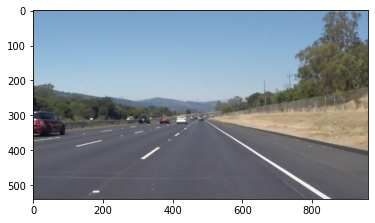

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#img = np.copy(image)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

In [3]:


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[250, 0, 0], thickness=8):
    """
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [4]:
class line():
    """
    Defining a line Class. A line will have a coordinate, slope and an intercept
    where y = Mx + b
    """
    def __init__(self, coordinate):
        x1, y1, x2, y2 = coordinate
        self.coordinates = coordinate
        self.slope = (y2 - y1) / (x2 - x1 + np.finfo(float).eps)
        self.b_line = y1 - self.slope * x1


def get_slope(coordinate):
    """
    Return slope and coordinates given the coordinates
    """
    x1, y1, x2, y2 = coordinate
    slope = (y2 - y1) / (x2 - x1 + np.finfo(float).eps)
    b_line = y1 - slope * x1
    return slope, b_line


def get_lanes(lines, img):
    """
    Returns infered lanes given the Hough transformed lines and the original image
    """
    

#     # convert to grayscale
#     im = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#     # perform gaussian blur
#     im = gaussian_blur(im, 17)

#     # perform edge detection
#     im = canny(im, 50, 80)

#     # perform hough transform
#     _, lines = hough_lines(img=im,
#                        rho=2,
#                        theta=np.pi / 180,
#                        threshold=1,
#                        min_line_len=15,
#                        max_line_gap=5)
    left_lane = []
    right_lane = []
    
    for l in lines:
        l = l[0]
        slope, bias = get_slope(l)
        if 0.5 <= np.abs(slope) <= 2:
            if slope < 0:
                left_lane.append(line(l))
            elif slope > 0:
                right_lane.append(line(l))
            
            
    left_bias = np.median([l.b_line for l in left_lane]).astype(int)
    left_slope = np.median([l.slope for l in left_lane])
    x1, y1 = 0, left_bias
    x2, y2 = -np.int32(np.round(left_bias / left_slope)), 0
    left_lane = (x1, y1, x2, y2)
    
    right_bias = np.median([l.b_line for l in right_lane]).astype(int)
    right_slope = np.median([l.slope for l in right_lane])
    x1, y1 = 0, right_bias
    x2, y2 = np.int32(np.round((img.shape[0] - right_bias) / right_slope)), img.shape[0]
    right_lane = (x1, y1, x2, y2)
    
    return right_lane, left_lane

In [5]:
def fetchline(image, canny_threshold = (50,80 ), 
              kernel_size=17,hough_threshold= 1 , min_line_len = 15, max_line_gap= 5,
              theta = np.pi/180, rho=2, straight = False):
    
    """
    Builds the Piepline for drawing the line
    Returns Image of drawn lanes
    """
    image = cv2.resize(image, (960, 540))
    img=image
    im = grayscale(image)
    im = gaussian_blur(im, kernel_size)
    
    
    low, high = canny_threshold
    im = canny(im, low, high)
    
    imshape = im.shape
    vertices = np.array([[(0,imshape[0]),(450, 320), (490, 310), (imshape[1],imshape[0])]], \
                        dtype=np.int32)
    im = region_of_interest(im, vertices)
  
    lines= hough_lines(im, rho, theta, hough_threshold, min_line_len, max_line_gap)
 
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    if straight:
        lines= [get_lanes(lines, img)]
        draw_lines(line_img, lines)
        line_img =region_of_interest(line_img, vertices)
    else:
         draw_lines(line_img, lines)
  
    im= weighted_img(line_img, initial_img=image, α=0.8, β=1., γ=0.)
  
    return im

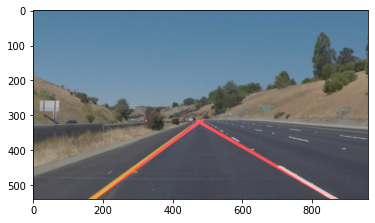

In [6]:

image = mpimg.imread('test_images/solidYellowCurve2.jpg')
plt.imshow(fetchline(image, straight=True ))

## Test Images

Test pipeline to work on the images in the directory "test_images"  


In [7]:
import os
direct = os.listdir("test_images/")
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

In [8]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

for i, nam in enumerate(direct):
    
    name = "test_images/"+nam
    print(name)
    image = mpimg.imread(name)
    img = fetchline(image)
    mpimg.imsave(f"test_images_output/{nam}", img)

test_images/solidWhiteRight.jpg
test_images/solidYellowCurve.jpg
test_images/whiteCarLaneSwitch.jpg
test_images/solidYellowCurve2.jpg
test_images/solidYellowLeft.jpg
test_images/solidWhiteCurve.jpg


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [9]:
# Uncomment to install these video requirements
# !pip install imageio
# !pip install imageio-ffmpeg
# !pip install movie-py

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
straight = True
def process_image(image):

    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global straight 
    result = fetchline(image, straight=straight)
    return result

Let's try the one with the solid white lane on the right first ...

In [12]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   9%|▊         | 19/221 [00:00<00:01, 186.42it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 5.31 s, sys: 1.78 s, total: 7.09 s
Wall time: 1.72 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [14]:
straight = True
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 17 s, sys: 5.96 s, total: 23 s
Wall time: 5.21 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [16]:
straight = True
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,3)
#clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   0%|          | 0/75 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 1.82 s, sys: 629 ms, total: 2.45 s
Wall time: 741 ms


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))